# Fast Hyperparameter Search

In [1]:
import math
import os
import time
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from pandarallel import pandarallel
from qiskit.providers import Backend
from qiskit.quantum_info import Statevector, partial_trace
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from squlearn import Executor
from squlearn.encoding_circuit import RandomLayeredEncodingCircuit
from squlearn.encoding_circuit.encoding_circuit_base import EncodingCircuitBase
from squlearn.observables import SummedPaulis
from squlearn.optimizers import Adam
from squlearn.qnn import CrossEntropyLoss, QNNClassifier
from utils.encoding_circuits import get_measurement_circuits
from utils.fast_eval import approx_cross_validate_random_encoding_circuit
from utils.pareto_plot import pareto_plot

In [2]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

### Approximation using Logistic Regression

Since the encoding circuit and observable represent critical hyperparameters and their exhaustive search is computationally expensive, let's try approximating their accuracy scores using classical machine learning algorithms. Therefore, we train a `LogisticRegression` model on the quantum-encoded features to evaluate whether the resulting accuracy serves as a reliable approximation for the actual accuracy.

<ins>Example</ins>

Quantum: $c_0  XII + c_1 IXI + c_2 IIX + c_3 ZII + c_4 IZI + c_5 IIZ + c_3 III$

Classical: $w_0 x_1 + w_1 x_2 + w_2 x_3 + w_3 z_1 + w_4 z_2 + w_5 z_3 + b$

In [5]:
def get_approx_train_score(
        encoding_circuit: EncodingCircuitBase,
        bases: str,
        X: np.ndarray,
        y: np.ndarray,
) -> float:
    quantum_states = [
        Statevector.from_instruction(encoding_circuit.get_circuit(example, None))
        for example in X
    ]
    num_qubits = encoding_circuit.num_qubits
    num_bases = len(bases)
    X_quantum = np.ndarray((len(X), num_qubits * num_bases))
    for state_idx, state in enumerate(quantum_states):
        feature_idx = 0
        for qubit in range(num_qubits):
            trace_indices = [i for i in range(num_qubits) if i != qubit]
            rho = partial_trace(state, trace_indices)
            if "X" in bases:
                X_quantum[state_idx, feature_idx] = float((rho.data[0, 1] + rho.data[1, 0]).real)
                feature_idx += 1
            if "Y" in bases:
                X_quantum[state_idx, feature_idx] = float((rho.data[1, 0] - rho.data[0, 1]).imag)
                feature_idx += 1
            if "Z" in bases:
                X_quantum[state_idx, feature_idx] = float((rho.data[0, 0] - rho.data[1, 1]).real)
                feature_idx += 1
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_quantum, y)
    return logistic_regression.score(X_quantum, y)

### Correlation of Approximation and Actual Score

Now, we need to find out whether the approximated score and the actual score are actually correlated.

In [6]:
def get_actual_train_score(encoding_circuit: EncodingCircuitBase, bases: str, X: np.ndarray, y: np.ndarray) -> float:
    qnn_classifier = QNNClassifier(
        encoding_circuit=encoding_circuit,
        operator=len(set(y)) * [SummedPaulis(num_qubits=encoding_circuit.num_qubits, op_str=tuple(bases))],
        loss=CrossEntropyLoss(),
        optimizer=Adam(),
        executor=Executor("qulacs"),
    )
    qnn_classifier.fit(X, y)
    return qnn_classifier.score(X, y)


def evaluate_random_encoding_circuit(
        num_qubits: int,
        num_features: int,
        seed: int,
        bases: str,
        X: np.ndarray,
        y: np.ndarray,
) -> dict[str, int | float]:
    num_layers = math.ceil(num_features / num_qubits)
    encoding_circuit = RandomLayeredEncodingCircuit(
        num_qubits=num_qubits,
        num_features=num_features,
        min_num_layers=num_layers,
        max_num_layers=num_layers,
        seed=seed,
    )
    approx_time = time.perf_counter()
    approx_score = get_approx_train_score(encoding_circuit, bases, X, y)
    approx_time = time.perf_counter() - approx_time
    actual_time = time.perf_counter()
    actual_score = get_actual_train_score(encoding_circuit, bases, X, y)
    actual_time = time.perf_counter() - actual_time
    return {
        "num_qubits": num_qubits,
        "num_features": num_features,
        "num_layers": num_layers,
        "bases": bases,
        "seed": seed,
        "approx_score": approx_score,
        "approx_time": approx_time,
        "actual_score": actual_score,
        "actual_time": actual_time,
    }


checkpoint_filename = "checkpoints/fast_hyperparam_search/correlation.csv"
columns = [
    "num_qubits",
    "num_features",
    "num_layers",
    "seed",
    "bases",
    "approx_score",
    "approx_time",
    "actual_score",
    "actual_time",
]

if not os.path.exists(checkpoint_filename):
    pd.DataFrame(columns=columns, data=[]).to_csv(checkpoint_filename, index=False)

finished_tasks = pd.read_csv(checkpoint_filename)
finished_tasks = set(zip(finished_tasks["num_qubits"], finished_tasks["seed"], finished_tasks["bases"]))

todo_tasks = [
    (num_qubits, seed, bases)
    for num_qubits in [1, 2, 3, 4, 5]
    for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    for bases in ["X", "Y", "Z", "XY", "XZ", "YZ", "XYZ"]
    if (num_qubits, seed, bases) not in finished_tasks
]

if todo_tasks:

    X_train_scaled = make_pipeline(
        Isomap(n_components=5),
        MinMaxScaler(feature_range=(-np.pi, np.pi), clip=True),
    ).fit_transform(X_train)

    with Parallel(
            n_jobs=min(os.cpu_count(), len(todo_tasks)),
            return_as="generator",
    ) as parallel:
        results_generator = parallel(
            delayed(evaluate_random_encoding_circuit)(
                num_qubits=num_qubits,
                num_features=5,
                seed=seed,
                bases=bases,
                X=X_train_scaled,
                y=y_train,
            ) for num_qubits, seed, bases in todo_tasks
        )
        for single_result in results_generator:
            pd.DataFrame(
                data=[single_result],
                columns=columns,
            ).to_csv(
                path_or_buf=checkpoint_filename,
                mode="a",
                header=False,
                index=False,
            )

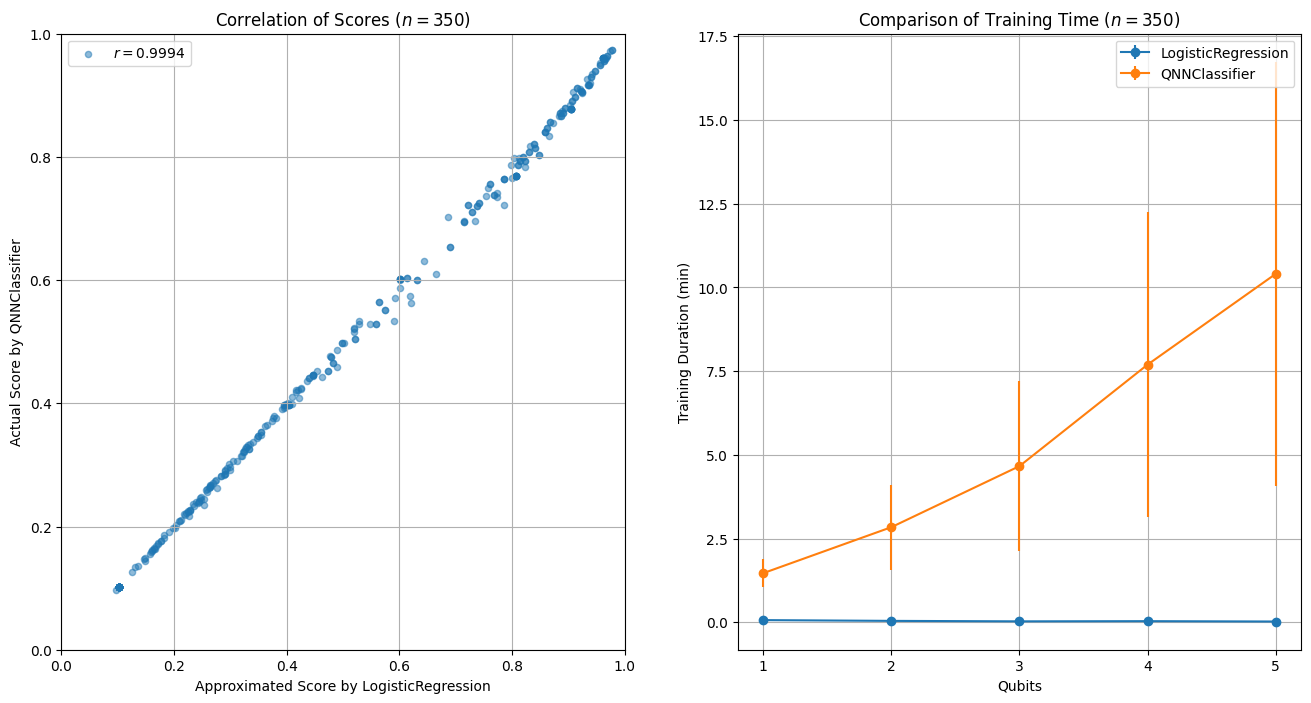

In [7]:
checkpoint_filename = "checkpoints/fast_hyperparam_search/correlation.csv"
data = pd.read_csv(checkpoint_filename)
num_qubits_values = data["num_qubits"].unique()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

r = np.corrcoef(data["approx_score"], data["actual_score"])[0, 1]
n = len(data)

data.plot(
    kind="scatter",
    x="approx_score",
    y="actual_score",
    ax=ax[0],
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel="Approximated Score by LogisticRegression",
    ylabel="Actual Score by QNNClassifier",
    title=f"Correlation of Scores ($n={n}$)",
    grid=True,
    alpha=0.5,
    label=f"$r={round(r, 4)}$",
)

training_time = data.groupby("num_qubits").agg({
    "approx_time": ["mean", "std"],
    "actual_time": ["mean", "std"]
}) / 60

training_time[[('approx_time', 'mean'), ('actual_time', 'mean')]].plot(
    kind="line",
    yerr=training_time[[('approx_time', 'std'), ('actual_time', 'std')]].values.T,
    marker="o",
    rot=0,
    xlabel="Qubits",
    ylabel="Training Duration (min)",
    xticks=num_qubits_values,
    grid=True,
    ax=ax[1],
    title=f"Comparison of Training Time ($n={n}$)"
)

ax[1].legend(["LogisticRegression", "QNNClassifier"])

plt.show()

### Accelerated Hyperparameter Search

Since the scores from the logistic regression approximation correlate strongly with the quantum neural network's actual accuracy, we are ready to launch the full hyperparameter search for the classification problem.

In [8]:
checkpoint_filename = "checkpoints/fast_hyperparam_search/search_results.csv"
columns = [
    "num_qubits",
    "num_features",
    "num_layers",
    "seed",
    "bases",
    "score",
]

if not os.path.exists(checkpoint_filename):
    pd.DataFrame(columns=columns, data=[]).to_csv(checkpoint_filename, index=False)

finished_tasks = pd.read_csv(checkpoint_filename)
finished_tasks = set(zip(
    finished_tasks["num_qubits"],
    finished_tasks["num_features"],
    finished_tasks["num_layers"],
    finished_tasks["seed"],
    finished_tasks["bases"],
))

todo_tasks = [
    (num_qubits, num_features, num_layers, seed, bases)
    for num_qubits in [1, 2, 3, 4, 5]
    for num_features in [5]
    for num_layers in [1, 2, 3, 4, 5]
    for seed in range(1000)
    for bases in ["X", "Y", "Z", "XY", "XZ", "YZ", "XYZ"]
    if num_qubits * num_layers >= num_features
       and (num_qubits, num_features, num_layers, seed, bases) not in finished_tasks
]

if todo_tasks:

    X_train_scaled = make_pipeline(
        Isomap(n_components=5),
        MinMaxScaler(feature_range=(-np.pi, np.pi), clip=True),
    ).fit_transform(X_train)

    with Parallel(
            n_jobs=min(os.cpu_count(), len(todo_tasks)),
            return_as="generator",
    ) as parallel:
        results_generator = parallel(
            delayed(approx_cross_validate_random_encoding_circuit)(
                num_qubits=num_qubits,
                num_features=num_features,
                num_layers=num_layers,
                seed=seed,
                bases=bases,
                X=X_train_scaled,
                y=y_train,
            ) for num_qubits, num_features, num_layers, seed, bases in todo_tasks
        )
        for single_result in results_generator:
            pd.DataFrame(
                data=[single_result],
                columns=columns,
            ).to_csv(
                path_or_buf=checkpoint_filename,
                mode="a",
                header=False,
                index=False,
            )

In [9]:
def get_num_gates_by_row(row: pd.Series, backend: Backend | None) -> int:
    encoding_circuit = RandomLayeredEncodingCircuit(
        num_qubits=row["num_qubits"],
        num_features=row["num_features"],
        min_num_layers=row["num_layers"],
        max_num_layers=row["num_layers"],
        seed=row["seed"],
    )
    observable = SummedPaulis(
        num_qubits=row["num_qubits"],
        op_str=tuple(row["bases"])
    )
    measurement_circuits = get_measurement_circuits(encoding_circuit, observable, backend)
    return sum(measurement_circuit.size() for measurement_circuit in measurement_circuits)


pandarallel.initialize(progress_bar=True)
checkpoint_filename = "checkpoints/fast_hyperparam_search/search_results.csv"
results = pd.read_csv(checkpoint_filename)
for backend in [None, FakeManilaV2()]:
    column_name = "num_gates_" + (backend.__class__.__name__.lower() if backend else "simulator")
    if column_name not in results.columns:
        results[column_name] = results.parallel_apply(lambda row: get_num_gates_by_row(row, backend), axis=1)
results.to_csv(checkpoint_filename, index=False)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Evaluation

In [10]:
def get_label_by_row(row: pd.Series) -> str:
    return f"s={row.seed},q={row.num_qubits},l={row.num_layers},b={row.bases}"


def plot_gates_vs_accuracy(results: pd.DataFrame, backend: Backend | None) -> None:
    title = f"{backend.__class__.__name__ if backend else 'Simulator'} ($n={len(results)}$)"
    num_gates = "num_gates_" + (backend.__class__.__name__.lower() if backend else "simulator")
    results = results.rename(columns={num_gates: "num_gates", "score": "accuracy"})
    pareto_plot(data=results, x="num_gates", y="accuracy", label=get_label_by_row, title=title)

In [11]:
checkpoint_filename = "checkpoints/fast_hyperparam_search/search_results.csv"
results = pd.read_csv(checkpoint_filename)

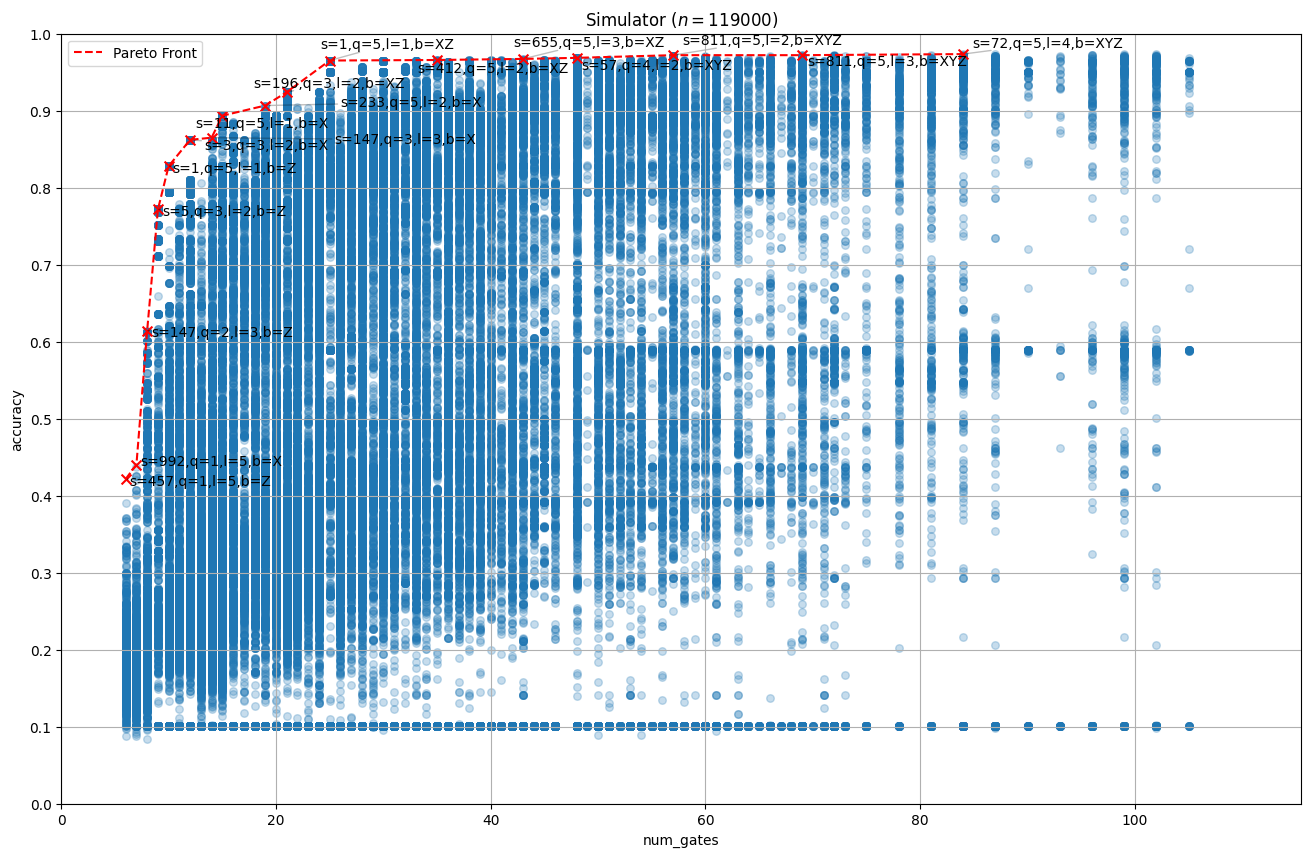

In [12]:
plot_gates_vs_accuracy(results, None)

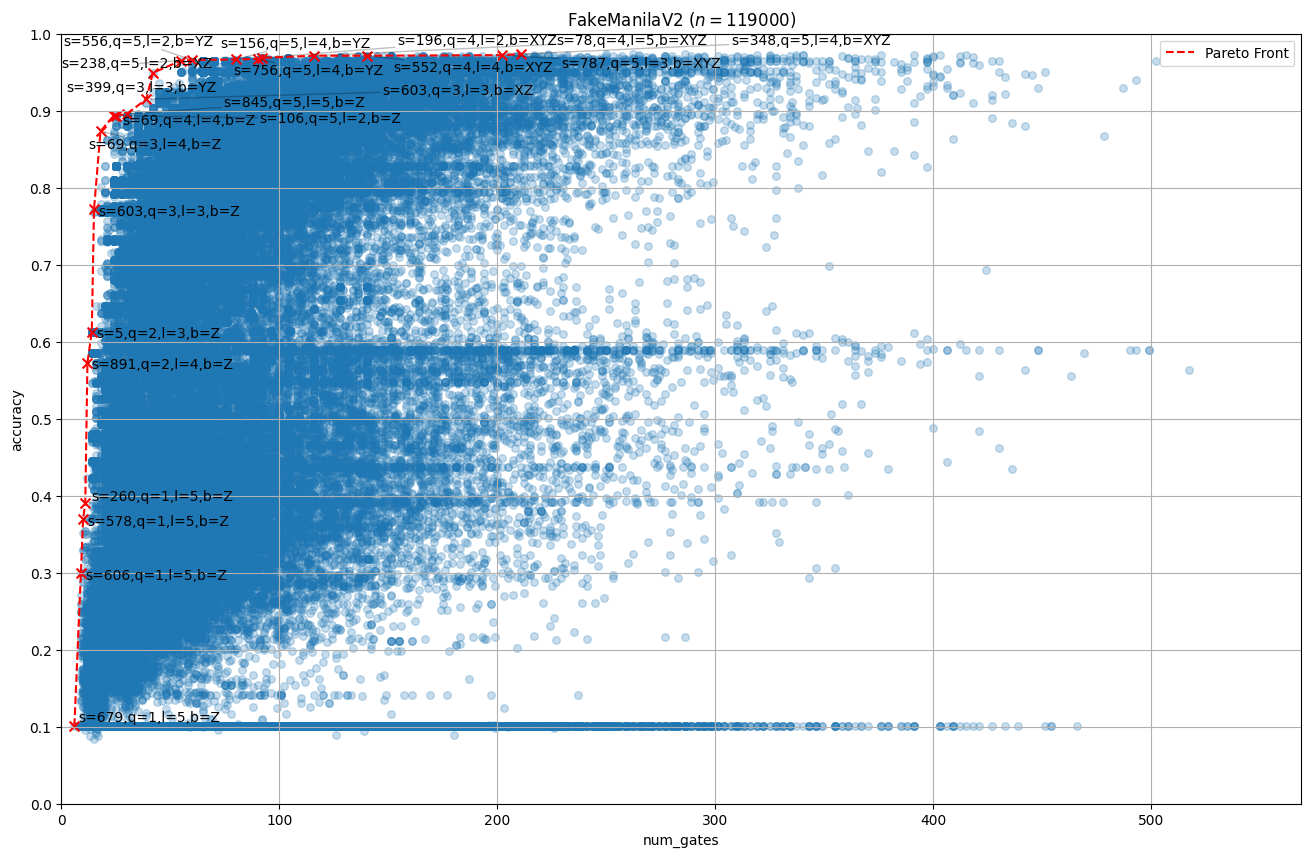

In [13]:
plot_gates_vs_accuracy(results, FakeManilaV2())

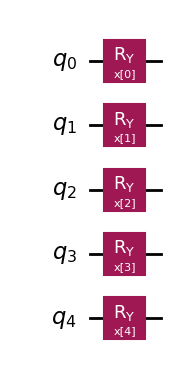

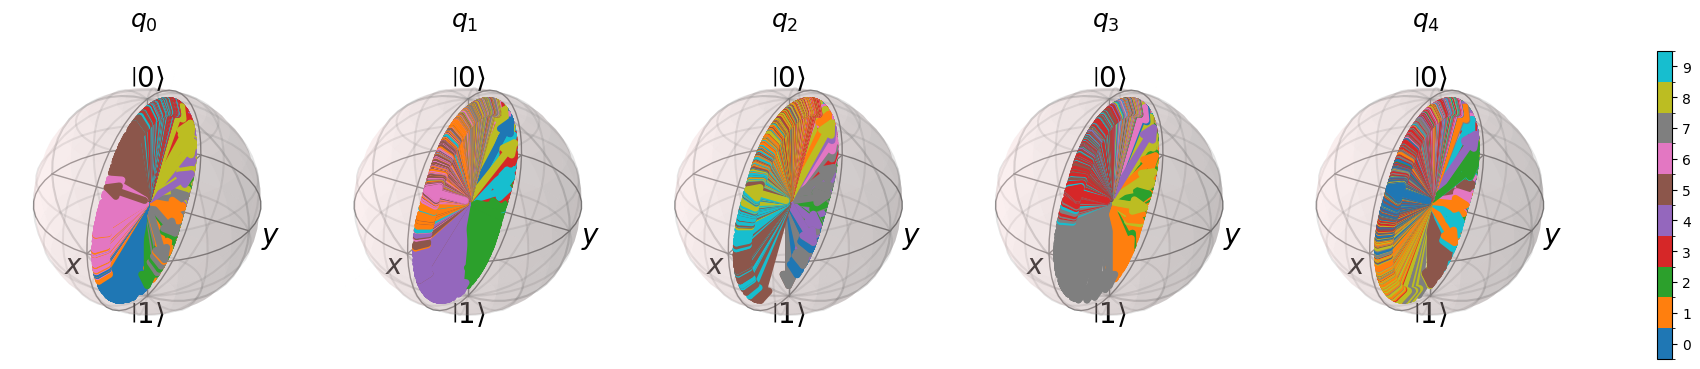

In [14]:
from utils.encoding_circuits import plot_encoded_quantum_data

X_train_scaled = make_pipeline(
    Isomap(n_components=5),
    MinMaxScaler(feature_range=tuple(encoding_circuit.feature_bounds), clip=True),
).fit_transform(X_train)
encoding_circuit.draw("mpl")
plot_encoded_quantum_data(encoding_circuit, X_train_scaled[:1000], y_train[:1000])